# Advanced  analysis

The advanced analysis is performed after having reconstructed the PET image with the correct and complete $\mu$-map.  The affine transformations (i.e., representing the rigid body alignment) of the two-stage registration are used again for aligning the concentric ring volumes of interest (VOI).

## Imports

In [1]:
# > get all the imports
import numpy as np
import os
import glob
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

from niftypet import nipet
from niftypet import nimpa

# > import tools for ACR parameters, 
# > templates generation and I/O
import acr_params as pars
import acr_tmplates as ast
import acr_ioaux as ioaux

## Initialisation

Initialise the scanner parameters and look-up tables, the path to the phantom data and design, and phantom constants, etc.

In [2]:
# > get all the constants and LUTs for the mMR scanner
mMRpars = nipet.get_mmrparams()

# > core path with ACR phantom inputs
cpth = Path('/sdata/ACR_data_design')

# > standard and exploratory output
outname = 'output_s'

# > get dictionary of constants, Cntd, for ACR phantom imaging
Cntd = pars.get_params(cpth)

# > update the dictionary of constants with I/O paths
Cntd = ioaux.get_paths(Cntd, mMRpars, cpth, outdir=outname)

## Qantitative PET reconstruction

Reconstruct the quantitative PET for iterations 4, 8 and 16 as given in `Cntd['itr_qnt2']`.  Uses the complete $\mu$-map as saved at path `Cntd['out']['fmuf']`.

In [3]:
# > adjust the time frame as needed
time_frame = [0, 1800]

# > output file name
facr = 'ACR_QNT_t{}-{}'.format(time_frame[0],  time_frame[1])

if not os.path.isfile(os.path.join(os.path.dirname(Cntd['fqnt']), facr+'.nii.gz')):
    # > generate hardware mu-map for the phantom
    muhdct = nipet.hdw_mumap(Cntd['datain'], [3,4], mMRpars, outpath=Cntd['opth'], use_stored=True)
    
    # > run reconstruction
    recon = nipet.mmrchain( 
        Cntd['datain'],                # > all the input data in dictionary
        mMRpars,
        frames=['fluid', [0,1800]],
        mu_h=muhdct, 
        mu_o=Cntd['out']['fmuf'],
        itr=max(Cntd['itr_qnt2']),
        store_itr=Cntd['itr_qnt2'],    # > list of all iterations after which image is saved
        recmod=3,
        outpath = Cntd['opth'],
        fout=facr,
        store_img = True)

## Scaling up PET images to high resolution grid

The PET images are trimmed and upsampled to ~$0.5$ mm resolution grid to facilitate accurate and precise concentric ring VOI sampling.

In [ ]:
# > TRIM/UPSCALE

# > get PET images for different iterations to be upsacled
fims = glob.glob(os.path.join(Cntd['opth'], 'PET', 'single-frame', facr+'*inrecon*'))

for fim in fims:
    imu = nimpa.imtrimup(
        fim,
        refim=Cntd['fnacup'],
        scale=Cntd['sclt'],
        int_order=1,
        fcomment_pfx=os.path.basename(fim).split('.')[0]+'_',
        store_img=True)

### Plot upscaled PET images
Notice, the inceased noise with a greater number of iterations, but also greater contrast achieved, especially seen on the summed images below.

In [4]:
#> get upscaled images for 4 and 16 OSEM iterations

fqnt4 = glob.glob(os.path.join(Cntd['opth'], 'PET', 'single-frame', 'trimmed', facr+'*itr4*inrecon*'))[0]
qntim4 = nimpa.getnii(fqnt4)
fqnt16 = glob.glob(os.path.join(Cntd['opth'], 'PET', 'single-frame', 'trimmed', facr+'*itr16*inrecon*'))[0]
qntim16 = nimpa.getnii(fqnt16)

Text(0.5, 1.0, 'Faceplate section, 16 iters')

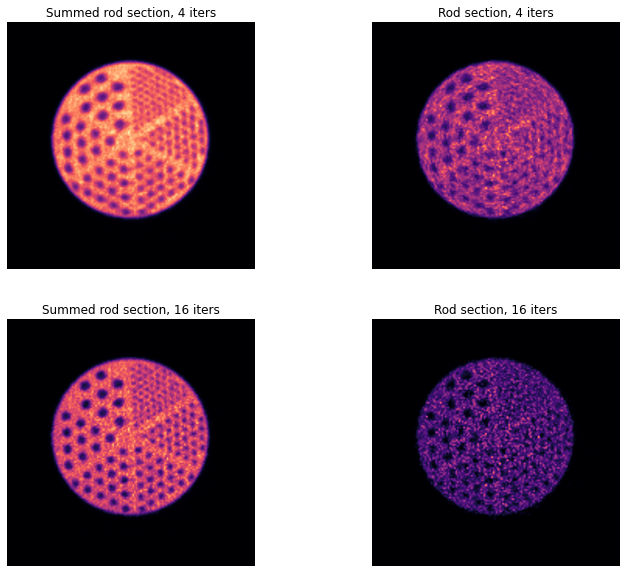

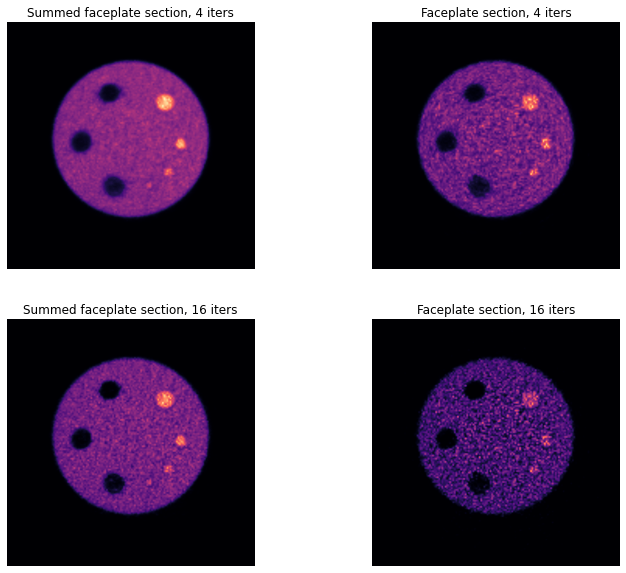

In [5]:
#> RODS
# > plot the NAC PET reconstruction and template
fig, axs = plt.subplots(2,2, figsize=(12, 10))

axs[0,0].imshow(np.sum(qntim4[90:240],axis=0), cmap='magma')
axs[0,0].set_axis_off()
axs[0,0].set_title('Summed rod section, 4 iters')

axs[0,1].imshow(qntim4[160,...], cmap='magma')
axs[0,1].set_axis_off()
axs[0,1].set_title('Rod section, 4 iters')

axs[1,0].imshow(np.sum(qntim16[90:240],axis=0), cmap='magma')
axs[1,0].set_axis_off()
axs[1,0].set_title('Summed rod section, 16 iters')

axs[1,1].imshow(qntim16[160,...], cmap='magma')
axs[1,1].set_axis_off()
axs[1,1].set_title('Rod section, 16 iters')

# FACEPLATE
# > plot the NAC PET reconstruction and template
fig, axs = plt.subplots(2,2, figsize=(12, 10))

axs[0,0].imshow(np.sum(qntim4[370:440],axis=0), cmap='magma')
axs[0,0].set_axis_off()
axs[0,0].set_title('Summed faceplate section, 4 iters')

axs[0,1].imshow(qntim4[400,...], cmap='magma')
axs[0,1].set_axis_off()
axs[0,1].set_title('Faceplate section, 4 iters')

axs[1,0].imshow(np.sum(qntim16[370:440],axis=0), cmap='magma')
axs[1,0].set_axis_off()
axs[1,0].set_title('Summed faceplate section, 16 iters')

axs[1,1].imshow(qntim16[400,...], cmap='magma')
axs[1,1].set_axis_off()
axs[1,1].set_title('Faceplate section, 16 iters')


#axs[1,1].imshow(np.sum(qntim4[],axis=0), cmap='magma')
#axs[1,1].set_axis_off()
#axs[1,1].set_title('Summed faceplate insert section')

## Generate the sampling templates

The templates are generated from high resolution PNG files and by repeating it in axial direction 3D NIfTI templates are generated.

In [ ]:
# > refresh all the input data and intermediate output
Cntd = pars.get_params(cpth)
Cntd = ioaux.get_paths(Cntd, mMRpars, cpth, outdir=outname)

# SAMPLING TEMPLATES
#> get the templates
ast.create_sampl_res(Cntd)
ast.create_sampl(Cntd)


## Generate sampling VOIs

The concentric sampling VOIs are generate by aligning all the templates to the upsampled PET

In [6]:
#> create the VOIs by resampling the templates
vois = ioaux.sampling_masks(Cntd, use_stored=True)

i> using sampling folder: /sdata/ACR_data_design/raw/output_s/PET/single-frame/sampling_masks
/sdata/ACR_data_design/templates/ACR-smpl/acr-res-sampling-0-2mm.nii.gz
/sdata/ACR_data_design/templates/ACR-smpl/acr-all-sampling-0-2mm.nii.gz
/sdata/ACR_data_design/templates/ACR-smpl/acr-insrt3-sampling-0-2mm.nii.gz
/sdata/ACR_data_design/templates/ACR-smpl/acr-ibckg-sampling-0-2mm.nii.gz


## Visualisation of VOI sampling
The left column shows the summed resolution rods and insert parts of the ACR phantom.  The right column shows the sampling concentric rings for the largest rods and the largest hot insert.

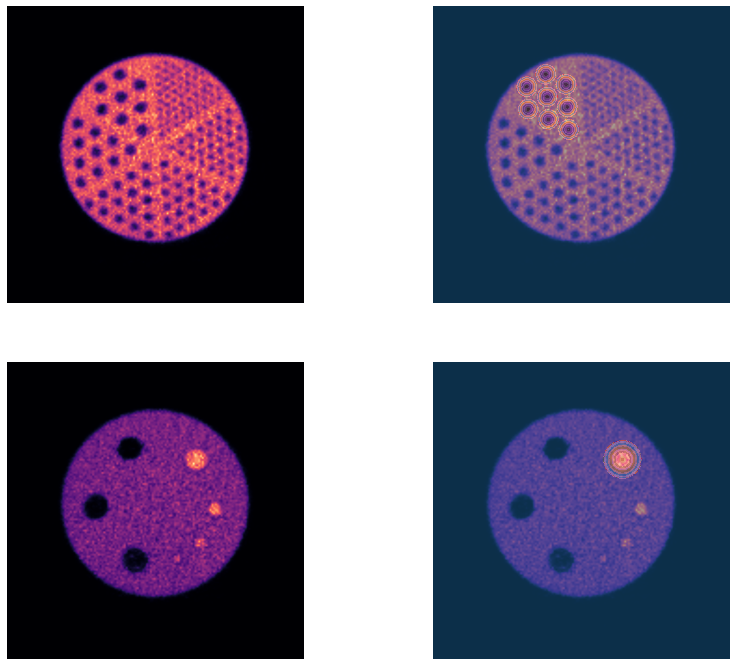

In [7]:
fig, axs = plt.subplots(2,2, figsize=(14, 12))

axs[0,0].imshow(np.sum(qntim16[90:240],axis=0), cmap='magma')
axs[0,0].set_axis_off()


axs[0,1].imshow(np.sum(qntim16[90:240],axis=0), cmap='magma')
axs[0,1].imshow(vois['fst_res'][150,...]*(vois['fst_res'][150,...]>=60), vmin=50, cmap='tab20', alpha=0.4)
axs[0,1].set_axis_off()

axs[1,0].imshow(np.sum(qntim16[370:440],axis=0), cmap='magma')
axs[1,0].set_axis_off()

axs[1,1].imshow(np.sum(qntim16[370:440],axis=0), cmap='magma')
axs[1,1].imshow(vois['fst_insrt'][400,...]*(vois['fst_insrt'][400,...]<20), vmin=0, cmap='tab20', alpha=0.4)
axs[1,1].set_axis_off()